In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import csv
import string
import requests
import io
import os
from zipfile import ZipFile
from tensorflow.contrib import learn
from tensorflow.python.framework import ops
ops.reset_default_graph()

import sys
reload(sys)
sys.setdefaultencoding('utf-8')

In [15]:
sess = tf.Session()

In [37]:
save_file_name = os.path.join('temp', 'temp_spam_data.csv')

if not os.path.exists('temp'):
    os.makedirs('temp')

if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
else:
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')

    text_data = file.decode()
    text_data = text_data.encode('ascii', errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x) >= 1]
    
    
    with open(save_file_name, 'w') as temp_output_file:
        write = csv.writer(temp_output_file)
        write.writerows(text_data)
        
texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]

In [40]:
target = [1 if x=='spam' else 0 for x in target]

texts = [x.lower() for x in texts]

texts = [''.join(c for c in x if c not in string.punctuation for x in texts)]
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]
texts = [' '.join(x.split()) for x in texts]

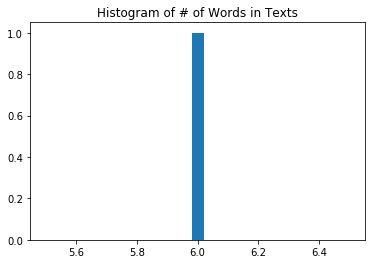

In [41]:
%matplotlib inline
text_lengths = [len(x.split()) for x in texts]
text_lengths = [x for x in text_lengths if x < 50]
plt.hist(text_lengths, bins=25)
plt.title('Histogram of # of Words in Texts')
plt.show()

In [19]:
sentence_size = 25
min_word_freq = 3

In [22]:
vocab_processor = learn.preprocessing.VocabularyProcessor(sentence_size, min_frequency=min_word_freq)
vocab_processor.transform(texts)
embedding_size = len([x for x in vocab_processor.transform(texts)])

In [24]:
train_indices = np.random.choice(len(texts), round(len(texts)*0.8), replace=False)
test_indices = np.array(list(set(range(len(texts))) - set(train_indices)))

texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]

target_train = [x for ix, x in enumerate(target) if ix in train_indices]
target_test = [x for ix, x in enumerate(target) if ix in test_indices]

TypeError: 'float' object cannot be interpreted as an index

In [26]:
identify_mat = tf.diag(tf.ones(shape =[embedding_size]))

A = tf.Variable(tf.random_normal(shape=[embedding_size, 1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))


x_data = tf.placeholder(shape=[sentence_size], dtype=tf.int32)
y_target = tf.placeholder(shape=[1,1], dtype=tf.float32)

In [27]:
x_embed = tf.nn.embedding_lookup(identify_mat, x_data)
x_ccl_sums = tf.reduce_sum(x_embed, 0)


x_col_sums_2D = tf.expand_dims(x_ccl_sums, 0)
model_output = tf.add(tf.matmul(x_col_sums_2D, A), b)

In [28]:
loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

prediction = tf.sigmoid(model_output)

my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

init = tf.global_variables_initializer()
sess.run(init)

In [32]:
# start logistic regression
print('Starting Training Over {} Sentences.'.format(len(texts_train)))

loss_vec = []
train_acc_all = []
train_acc_avg = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_train)):
    y_data = [target_train[ix]]
    
    sess.run(train_step, feed_dict={x_data: t, y_target: y_data})
    temp_loss = sess.run(loss, feed_dict={x_data: t, y_target: y_data})
    loss_vec.append(temp_loss)
    
    if (ix + 1) % 10 == 0:
        print('Training Observation #' + str(ix + 1) + ': Loss = ' + str(temp_loss))
    
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data: t, y_target: y_data})
    
    train_acc_temp = target_train[ix] == np.round(temp_pred)
    train_acc_all.append(train_acc_temp)
    if len(train_acc_all) >= 50:
        train_acc_avg.append(np.mean(train_acc_all[-50:]))

NameError: name 'texts_train' is not defined

In [34]:
print('Getting Test Set Accuracy for {} Sentences.' .format(len(texts_test)))
test_acc_all = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_test)):
    y_data = [[target_test[ix]]]
    
    if (ix + 1) % 50 == 0:
        print('Test Observation #' + str(ix + 1))

    [[temp_pred]] = sess.run(prediction, feed_dict={x_data:t, y_target: y_data})
    test_acc_temp = target_test[ix] == np.round(temp_pred)
    test_acc_all.append(test_acc_temp)
    
print('\n Overall Test Accuracy: {}'.format(np.mean(test_acc_all)))

NameError: name 'texts_test' is not defined

In [36]:
%matplotlib inline
plt.plot(range(len(train_acc_avg), train_acc_avg, 'k-', label ='Train Accuracy'))
plt.title('Avg Training Acc Over past 50 Iterations')
plt.xlabel('Iterations')
plt.ylabel("Training Accuracy")
plt.show()

NameError: name 'train_acc_avg' is not defined